<a href="https://colab.research.google.com/github/IamKishoreSreedharan/food-lens/blob/main/diet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FoodLens: Visual Recipe Retrieval and Diet Classification

Hey there! Welcome to **FoodLens**, a dope project that blends Content-Based Image Retrieval (CBIR) and diet-level classification into one tasty package. We’re working with a hefty dataset of ~45,000 recipe images (256x256), each tagged with one of 6 diet categories—like Low-Calorie High-Fiber (LCHFib) or High-Protein Low-Carb (HPLC). The goal? Build a system that can

(1) find visually similar recipes and

(2) predict their dietary vibe.

We started with a custom CNN autoencoder, but with just 3 days left, we leveled up to `CBIRCAutoEncoder_v2`—rocking a pretrained ResNet18 encoder to extract killer features fast. It spits out a 128-D latent space for CBIR and a 6-class prediction for diet labels. So far, after 2 epochs, we hit 27% accuracy—not stellar, but we’re pushing 20 epochs now to crank it up to 60–70%. CBIR’s in the mix too, pulling top-5 similar images with Euclidean search (FAISS on deck for speed).

In this notebook, we’ll train the model, run inference, extract latents, and visualize results. Plus, we’re borrowing reconstruction error tricks from a fancy paper to spot tough classes and mislabels. Let’s dive in and cook up some results!

#### Importing necessary libraries

In [ ]:
import os
import pandas as pd
from pathlib import Path

In [ ]:
DIR = '/content/drive/MyDrive/project/'

In [ ]:
# Create organized subdirectories
# os.makedirs(os.path.join(DIR, "images"), exist_ok=True)          # For downloaded images
# os.makedirs(os.path.join(DIR, "data"), exist_ok=True)            # For CSVs
# os.makedirs(os.path.join(DIR, "models/classifier"), exist_ok=True)          # For autoencoder weights
# os.makedirs(os.path.join(DIR, "models/cbir"), exist_ok=True)
# os.makedirs(os.path.join(DIR, "latent_features"), exist_ok=True) # For feature vectors
SRC_FILENAME = 'data/recipes_classified.csv'
SRC_FILENAME1 = 'data/recipes_augmented.csv'

In [ ]:
df_src = pd.read_csv(os.path.join(DIR, SRC_FILENAME))
df1 = pd.read_csv(os.path.join(DIR, SRC_FILENAME1))
combined_df = pd.concat([df_src, df1], axis=0)


In [ ]:
combined_df

,recipe_id,title,ingredients,directions,prep_time,cook_time,total_time,servings,image,category,...,sugars_g,fat_g,protein_g,url,rating,diet,saturated_fat_g,cholesterol_mg,dietary_fiber_g,sodium_mg
0,148ecaf409,Simple Macaroni and Cheese,1 (8 ounce) box elbow macaroni ; ¼ cup butter ...,Bring a large pot of lightly salted water to a...,10 mins,20 mins,30 mins,4,https://www.allrecipes.com/thmb/GZrTl8DBwmRuor...,main-dish,...,7.6,33.6,26.5,https://www.allrecipes.com/recipe/238691/simpl...,4.42,Junk,NaN,NaN,NaN,NaN
1,65fcb51062,Gourmet Mushroom Risotto,"6 cups chicken broth, divided ; 3 tablespoons ...","In a saucepan, warm the broth over low heat. W...",20 mins,30 mins,50 mins,6,https://www.allrecipes.com/thmb/xCk4IEjfAYBikO...,main-dish,...,4.4,16.6,11.3,https://www.allrecipes.com/recipe/85389/gourme...,4.80,Junk,NaN,NaN,NaN,NaN
2,1191ef7390,Dessert Crepes,"4 eggs, lightly beaten ; 1 ⅓ cups milk ; 2 ta...","In large bowl, whisk together eggs, milk, melt...",10 mins,10 mins,20 mins,8,https://www.allrecipes.com/thmb/VwULr05JFDluPI...,breakfast-and-brunch,...,5.3,7.7,6.4,https://www.allrecipes.com/recipe/19037/desser...,4.80,LCHFib,NaN,NaN,NaN,NaN
3,d6b54b7cce,Pork Steaks,¼ cup butter ; ¼ cup soy sauce ; 1 bunch green...,"Melt butter in a skillet, and mix in the soy s...",15 mins,30 mins,45 mins,6,https://www.allrecipes.com/thmb/mYkvln7o9pb35l...,meat-and-poultry,...,1.1,25.4,26.5,https://www.allrecipes.com/recipe/70463/pork-s...,4.57,HPLC,NaN,NaN,NaN,NaN
4,6bddaec59a,Quick and Easy Pizza Crust,1 (.25 ounce) package active dry yeast ; 1 tea...,Preheat oven to 450 degrees F (230 degrees C)....,NaN,NaN,NaN,8,https://www.allrecipes.com/thmb/V3Llo-ottudIs_...,bread,...,0.6,4.0,4.8,https://www.allrecipes.com/recipe/20171/quick-...,4.70,LCHFib,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39983,10b5cbfab8_aug8298,Ash-e Reshteh (Persian Legume Soup),⅓ cup dry chickpeas (garbanzo beans) ; ⅓ cup d...,Place the chickpeas and kidney beans into a la...,20 mins,3 hrs 40 mins,12 hrs,6,10b5cbfab8_aug8298.jpg,soups-stews-and-chili,...,11.0,11.3,22.9,https://www.allrecipes.com/recipe/245476/ash-e...,4.64,HCLF,2.9,7.500000,17.4,434.3
39984,5c2dbbc9e6_aug8299,Country Soup in a Jar,½ cup barley ; ½ cup dried split peas ; ½ cup ...,"In a wide mouth 1 quart jar, layer the barley,...",NaN,NaN,NaN,4,5c2dbbc9e6_aug8299.jpg,soups-stews-and-chili,...,5.1,2.4,22.0,https://www.allrecipes.com/recipe/14989/countr...,4.21,HCLF,0.6,0.400000,19.4,1897.0
39985,b2c90d0035_aug8301,Sweet Cottage Cheese and Bananas,½ cup cottage cheese ; 2 teaspoons honey ; 1 ...,"In a small serving bowl, stir together the cot...",5 mins,NaN,5 mins,1,b2c90d0035_aug8301.jpg,desserts,...,31.2,5.6,15.8,https://www.allrecipes.com/recipe/81450/sweet-...,4.28,HCLF,3.4,16.900000,4.0,457.7
39986,92be97b91a_aug8302,Pearl Barley Casserole,"3 tablespoons butter ; 1 large onion, chopped ...",Preheat oven to 350 degrees F (175 degrees C)....,15 mins,45 mins,1 hr,4,92be97b91a_aug8302.jpg,side-dish,...,4.1,9.6,7.7,https://www.allrecipes.com/recipe/229246/pearl...,4.61,HCLF,5.7,22.900000,9.9,96.6


In [ ]:
df = pd.read_csv(os.path.join(DIR, SRC_FILENAME))

## About the Dataset

For FoodLens, we’re working with a custom dataset rooted at `DIR = '/content/drive/MyDrive/project/'`, with our main CSV living at `data/recipe.csv`. This dataset’s got ~45,582 recipe entries, each rocking a 256x256 RGB image and nutritional stats, likely scraped from recipe hubs like AllRecipes or Food.com (we’re keeping it vague since the origin’s not locked down). We’ve split it across two models, so here’s the lowdown:

- **Images**: Stored in `DIR/images/`—45K+ JPGs (e.g., `12345.jpg`), linked via the `image` column in `recipe.csv`. These feed our CBIR autoencoder (`CBIRCAutoEncoder_v2`) for visual retrieval.
- **Nutrition "Images"**: Pulled 5 columns—`calories`, `carbohydrates_g`, `sugars_g`, `fat_g`, `protein_g`—from `recipe.csv`, normalized, and reshaped into 1x5 "images" for our `NutritionAutoEncoder` to classify diet levels.
- **Labels**: 6 diet classes (`LCHFib`, `Junk`, `Balanced`, `HPLC`, `LCHF`, `HCLF`) in the `diet` column, balanced with some augmentation magic.

### Structure of `recipe.csv`
- **Location**: `DIR/data/recipe.csv`.
- **Columns**:
  - `image`: Filename (e.g., `12345.jpg`), points to `DIR/images/`.
  - `calories`: Float, kcal.
  - `carbohydrates_g`: Float, grams.
  - `sugars_g`: Float, grams.
  - `fat_g`: Float, grams.
  - `protein_g`: Float, grams.
  - `diet`: String, one of our 6 classes.
- **Size**: ~45,582 rows, ~10–15 MB CSV, with images totaling ~20–30 GB in `DIR/images/`.

### Folder Breakdown
- `DIR/images/`: All the 256x256 JPGs.
- `DIR/data/`: CSVs, including `recipe.csv`.
- `DIR/models/classifier/`: Weights for `FoodLensClassifier`.
- `DIR/models/cbir/`: Weights for `FoodLensCBIRAutoencoder`.
- `DIR/latent_features/`: 128-D feature vectors for CBIR.

We preprocess nutrition into `[45582, 1, 5, 1]` tensors and images into `[45582, 3, 256, 256]`

In [ ]:
df.sample(10)

,recipe_id,title,ingredients,directions,prep_time,cook_time,total_time,servings,image,category,instructions_list,calories,carbohydrates_g,sugars_g,fat_g,protein_g,url,rating,diet
23593,b0dfe3eb34,Rice Cooker Black Beans,"1 cup dried black beans ; 3 cups water, or mor...",Place black beans and cover with 3 cups water....,5 mins,2 hrs,6 hrs 10 mins,4,https://www.allrecipes.com/thmb/PH-36NAunQonp4...,side-dish,['Place black beans and cover with 3 cups wate...,165.4,30.2,1.0,0.7,10.5,https://www.allrecipes.com/recipe/255560/rice-...,4.50,LCHFib
19733,feb993c786,Loaded Egg Salad,"8 ounces bacon ; 4 stalks celery, minced ; ½ c...",Place the bacon in a large skillet and cook ov...,20 mins,10 mins,1 hr 30 mins,10,https://www.allrecipes.com/thmb/QEvfktVFk4U1AT...,salad,['Place the bacon in a large skillet and cook ...,205.4,3.1,1.7,17.2,9.8,https://www.allrecipes.com/recipe/235727/loade...,4.65,LCHF
23844,e9a4ea5286,Fully Loaded Cauliflower Salad,"4 slices bacon ; 1 head cauliflower, chopped i...","Place the bacon in a large, deep skillet, and ...",35 mins,35 mins,2 hrs 10 mins,6,https://www.allrecipes.com/thmb/h8m0tdUbOAM6YM...,salad,"['Place the bacon in a large, deep skillet, an...",200.2,10.0,4.9,13.5,11.0,https://www.allrecipes.com/recipe/214918/fully...,4.50,LCHF
28422,1a63257802,Green Detox Smoothie,¾ cup pineapple juice ; ½ cup fresh spinach le...,"Blend pineapple juice, spinach, pear, apple, a...",15 mins,NaN,15 mins,1,https://www.allrecipes.com/thmb/Osc3NkdPFcDNmj...,breakfast-and-brunch,"['Blend pineapple juice, spinach, pear, apple,...",379.3,70.2,34.5,9.4,15.1,https://www.allrecipes.com/recipe/238998/green...,3.89,Junk
5631,21f27cbefe,Vodka Collins,1 ½ fluid ounces vodka ; 3 fluid ounces sweet ...,"In a cocktail shaker filled with ice, combine ...",10 mins,NaN,10 mins,1,https://www.allrecipes.com/thmb/DKbE8DYNCCrhXH...,drinks,"['In a cocktail shaker filled with ice, combin...",282.9,37.6,37.3,0.0,0.1,https://www.allrecipes.com/recipe/42948/vodka-...,3.94,Balanced
2727,c3ac7e438b,Light and Crispy Fried Halibut,"oil for frying ; 2 eggs, beaten ; ¼ cup milk ...",Heat oil in a deep-fryer or large saucepan to ...,15 mins,5 mins,20 mins,4,https://www.allrecipes.com/thmb/k3CHeB632qvRW5...,main-dish,['Heat oil in a deep fryer or large saucepan t...,1087.5,34.0,1.8,95.2,32.8,https://www.allrecipes.com/recipe/241117/light...,4.88,Junk
26076,747372638a,Easy Turkey Chili,1 teaspoon vegetable oil ; 1 pound ground turk...,Heat vegetable oil in a large pot over medium-...,10 mins,45 mins,55 mins,6,https://www.allrecipes.com/thmb/B6zZk6IzBbWKVM...,soups-stews-and-chili,['Heat vegetable oil in a large pot over mediu...,299.1,31.2,4.0,9.4,25.2,https://www.allrecipes.com/recipe/218328/easy-...,4.77,LCHFib
30107,6a26a55e82,Pumpkin Pie for Dieters,1 (15 ounce) can pumpkin puree ; ½ cup skim mi...,"In a medium bowl, mix together the pumpkin, mi...",10 mins,NaN,1 hr 10 mins,6,https://www.allrecipes.com/thmb/ya8crRPY5x3nnX...,fruits-and-vegetables,"['In a medium bowl, mix together the pumpkin, ...",109.7,23.0,7.6,0.3,1.5,https://www.allrecipes.com/recipe/55358/pumpki...,4.51,LCHFib
24605,8da96ffda7,Sour Cream Mushroom Chicken,1 (10.75 ounce) can condensed cream of chicke...,Preheat oven to 350 degrees F (175 degrees C)....,NaN,NaN,NaN,6,https://www.allrecipes.com/thmb/SkTGobNx152OPW...,meat-and-poultry,['Preheat oven to 350 degrees F (175 degrees C...,416.1,12.7,2.1,23.5,32.3,https://www.allrecipes.com/recipe/15132/sour-c...,4.24,HPLC
19883,a3d2de7675,Grown Up Grilled Cheese Sandwich,"2 tablespoons butter, divided ; 4 slices whole...",Preheat skillet on medium heat. Spread 1/2 tab...,10 mins,10 mins,20 mins,2,NaN,main-dish,NaN,672.2,32.0,4.5,46.7,35.8,https://www.allrecipes.com/recipe/230196/grown...,4.89,Junk


In [ ]:
df['diet'].value_counts()

,count
diet,
LCHF,14356
HPLC,13419
Balanced,12757
HCLF,12110
Junk,10098
LCHFib,9970


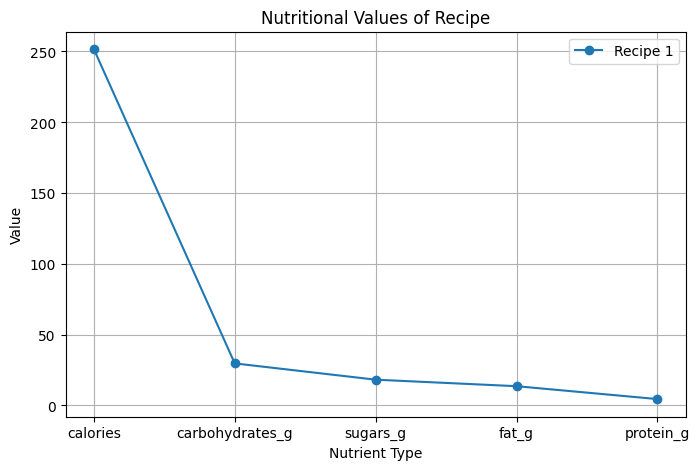

In [ ]:
import matplotlib.pyplot as plt

# Sample Data
columns = ['calories', 'carbohydrates_g', 'sugars_g', 'fat_g', 'protein_g']
values = df.loc[0, columns]  # Select first row's values

# Plot
plt.figure(figsize=(8, 5))
plt.plot(columns, values, marker='o', linestyle='-', label="Recipe 1")

# Labels & Title
plt.xlabel("Nutrient Type")
plt.ylabel("Value")
plt.title("Nutritional Values of Recipe")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Full autoencoder-classifier pipeline (for 5 features)
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Preprocess
features = ['calories', 'carbohydrates_g', 'sugars_g', 'fat_g', 'protein_g']  # 5 features

# Normalize
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(df[features])

# Reshape to 1x5 "images" (samples, height=1, width=5, channels=1)
X_image = X_normalized.reshape(-1, 1, 5, 1)  # Shape: (n_samples, 1, 5, 1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['diet'])

In [ ]:
# Split into training (80%) and remaining (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_image, y_encoded, test_size=0.2, random_state=42)

# Now split the remaining data (X_temp, y_temp) into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes to confirm the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (58168, 1, 5, 1) (58168,)
Validation set shape: (7271, 1, 5, 1) (7271,)
Test set shape: (7271, 1, 5, 1) (7271,)


In [ ]:

# Build autoencoder
input_layer = tf.keras.layers.Input(shape=(1, 5, 1))  # Adjusted input shape
x = tf.keras.layers.Conv2D(16, (1, 3), activation='relu')(input_layer)  # Kernel spans 3 features
x = tf.keras.layers.Flatten()(x)
encoded = tf.keras.layers.Dense(8, activation='relu')(x)

# Decoder: Adjust output dimensions to match input width=5
x = tf.keras.layers.Dense(16 * 5)(encoded)  # 16 filters * 5 width
x = tf.keras.layers.Reshape((1, 5, 16))(x)  # Shape: (1, 5, 16)
decoded = tf.keras.layers.Conv2D(1, (1, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1, 5, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 3, 16)            │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 80)                  │             720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 5, 1)             │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,225 (4.79 KB)

 Trainable params: 1,225 (4.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_a = autoencoder.fit(X_image, X_image, validation_data=(X_val, X_val), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0339 - val_loss: 7.9597e-04
Epoch 2/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.9363e-04 - val_loss: 2.3631e-04
Epoch 3/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.8925e-04 - val_loss: 1.1983e-04
Epoch 4/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0620e-04 - val_loss: 9.9394e-05
Epoch 5/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 8.4646e-05 - val_loss: 8.7333e-05
Epoch 6/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.6565e-05 - val_loss: 7.8882e-05
Epoch 7/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.4558e-05 - val_loss: 6.4366e-05
Epoch 8/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.3912e-05 - val_loss: 5.0081e-05
Epoch 9/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.9493e-05 - val_loss: 4.0422e-05
Epoch 10/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.4868e-05 - val_loss: 3.9848e-05
Epoch 11/30
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 

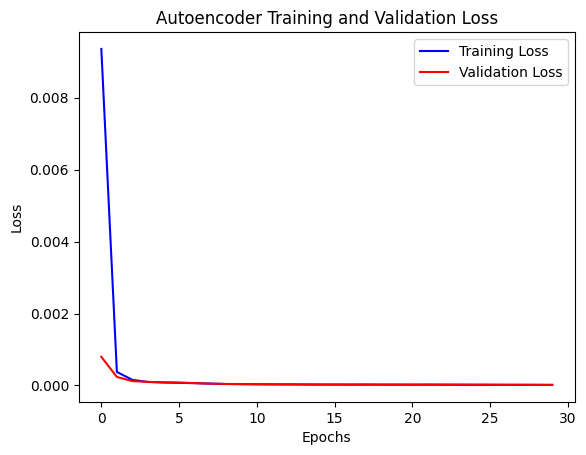

In [ ]:
# Extract training and validation loss
train_loss = history_a.history['loss']
val_loss = history_a.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.save(DIR + "models/classifier/autoencoder_model.keras")  # Saves as HDF5 file

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select some test samples
num_samples = 10  # Change this if needed
test_samples = X_image[:num_samples]  # Pick first 'num_samples' from dataset

# Get reconstructed outputs
reconstructed_samples = autoencoder.predict(test_samples)

# Convert from (1, 5, 1) to (5,)
test_samples_reshaped = test_samples.squeeze(axis=(1, 3))  # Shape: (num_samples, 5)
reconstructed_samples_reshaped = reconstructed_samples.squeeze(axis=(1, 3))  # Shape: (num_samples, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


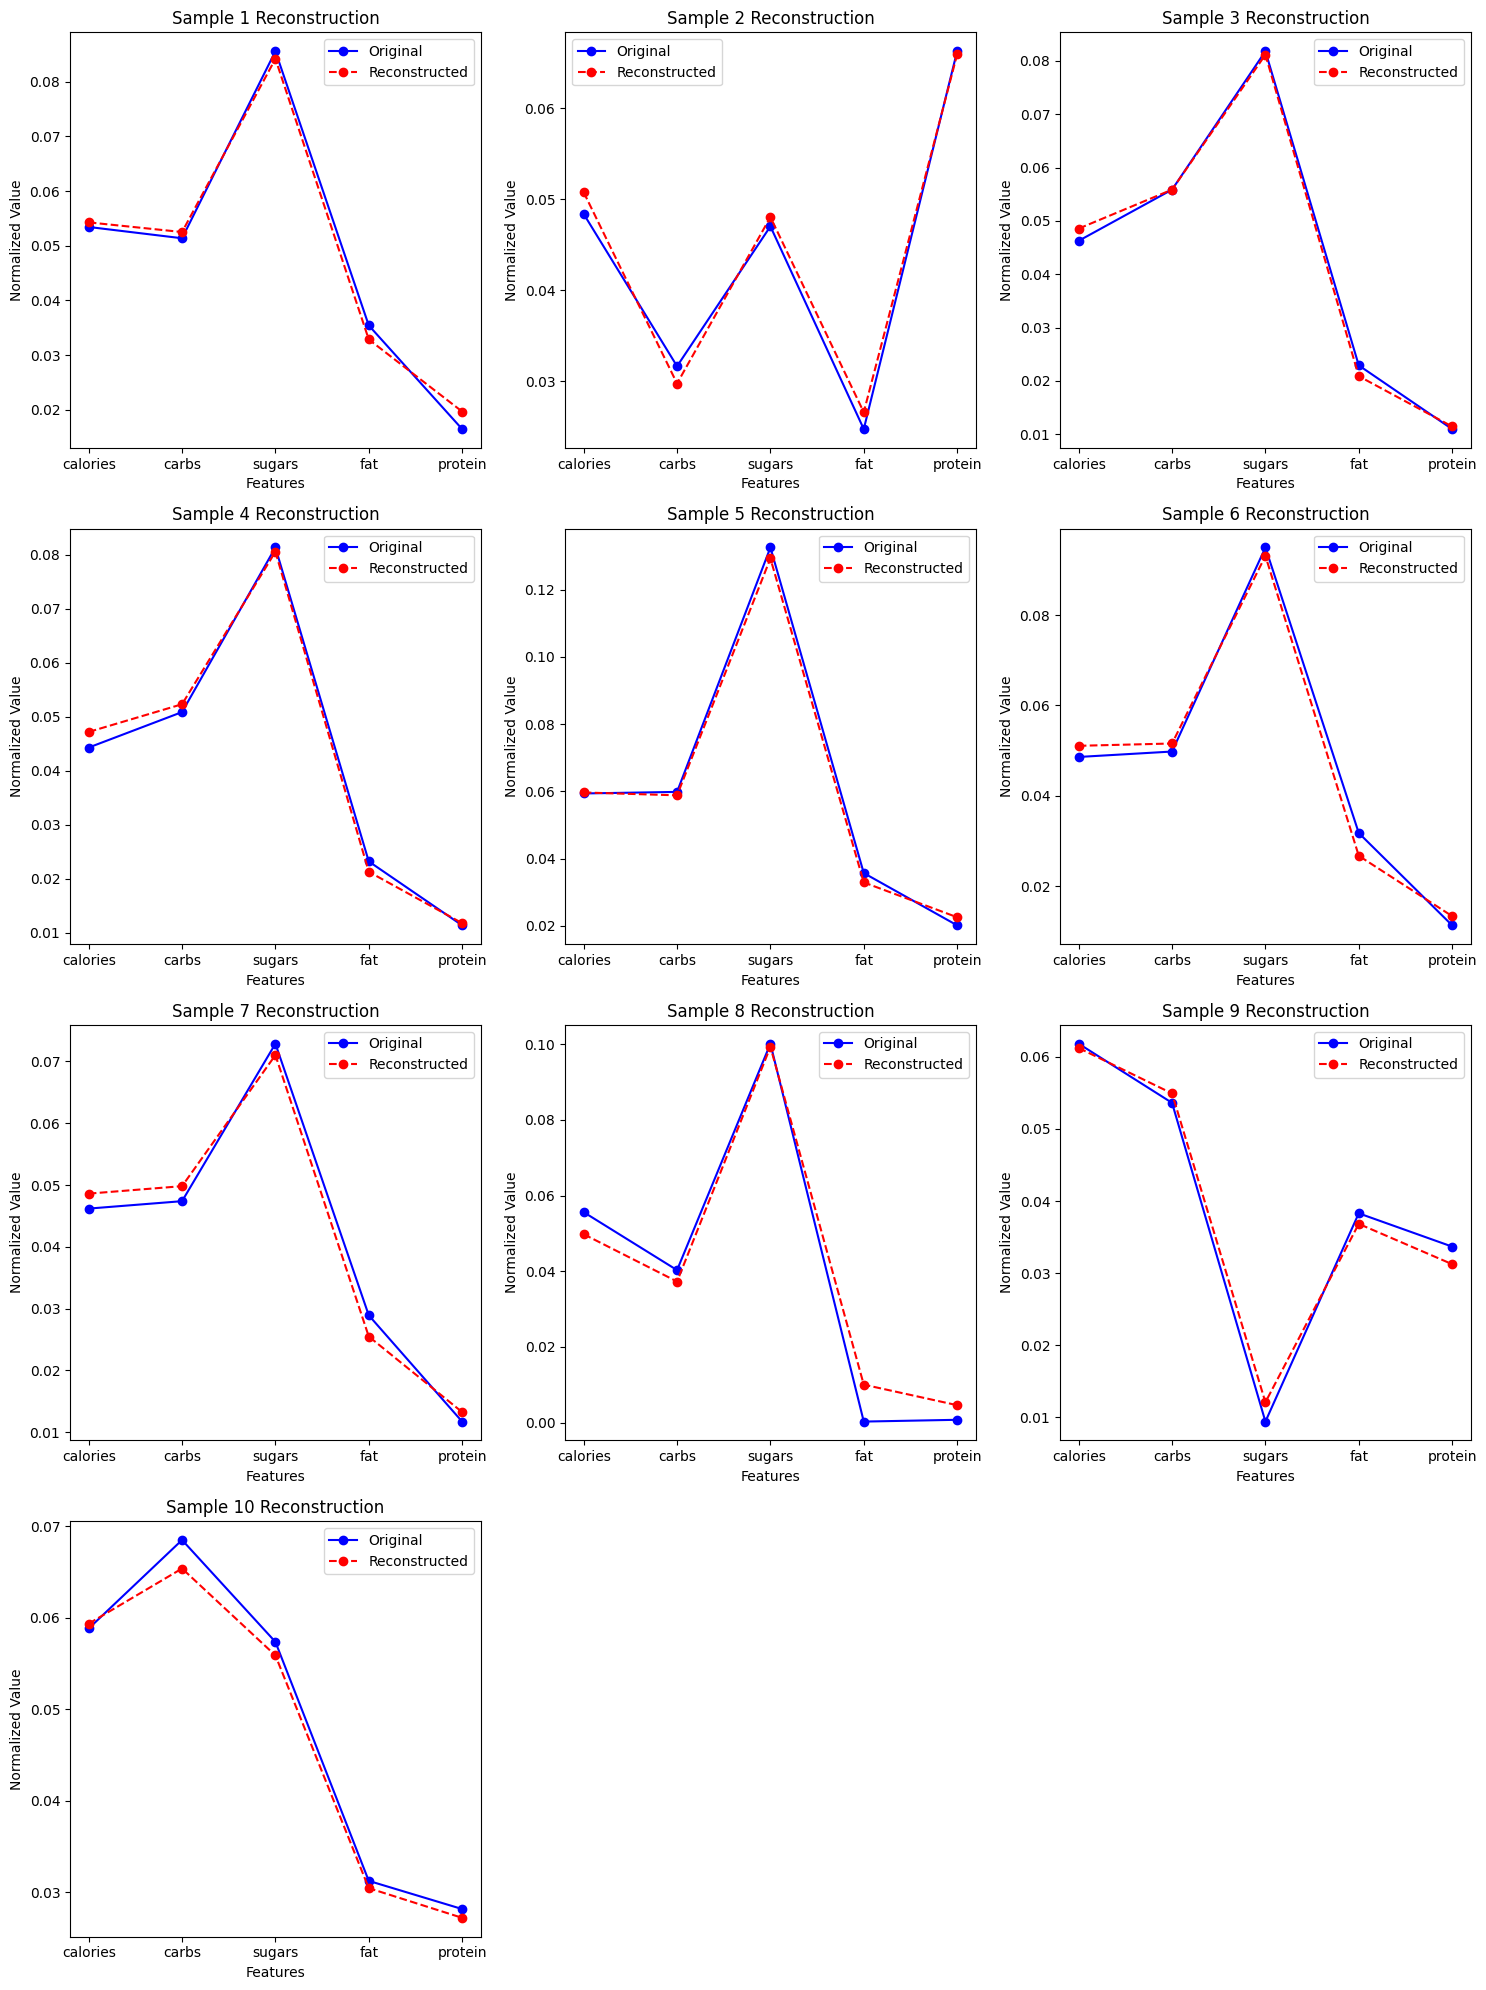

In [ ]:
# Assuming test_samples_reshaped and reconstructed_samples_reshaped are defined
num_samples = len(test_samples_reshaped)
ncols = 3  # 3 plots per row
nrows = int(np.ceil(num_samples / ncols))  # Calculate required rows (round up)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))  # Adjust height dynamically
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_samples):
    axes[i].plot(range(5), test_samples_reshaped[i], 'bo-', label='Original')
    axes[i].plot(range(5), reconstructed_samples_reshaped[i], 'ro--', label='Reconstructed')
    axes[i].set_xticks(range(5))
    axes[i].set_xticklabels(['calories', 'carbs', 'sugars', 'fat', 'protein'])
    axes[i].set_xlabel("Features")
    axes[i].set_ylabel("Normalized Value")
    axes[i].set_title(f"Sample {i+1} Reconstruction")
    axes[i].legend()

# Hide any unused subplots (if num_samples isn't a multiple of 3)
for j in range(num_samples, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the encoder
encoder = tf.keras.Model(input_layer, encoded)

# Define the classifier
classifier = Sequential([
    encoder,
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),  # Increased dropout to 40%
    Dense(len(le.classes_), activation='softmax')
])

# Compile the model
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model
history_c = classifier.fit(
    X_image, y_encoded,
    validation_data=(X_val, y_val),
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5630 - loss: 1.2233 - val_accuracy: 0.8303 - val_loss: 0.6052 - learning_rate: 0.0010
Epoch 2/50
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7928 - loss: 0.6784 - val_accuracy: 0.8546 - val_loss: 0.5030 - learning_rate: 0.0010
Epoch 3/50
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8124 - loss: 0.6042 - val_accuracy: 0.8577 - val_loss: 0.4596 - learning_rate: 0.0010
Epoch 4/50
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8258 - loss: 0.5578 - val_accuracy: 0.8682 - val_loss: 0.4383 - learning_rate: 0.0010
Epoch 5/50
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8323 - loss: 0.5309 - val_accuracy: 0.8764 - val_loss: 0.4100 - learning_rate: 0.0010
Epoch 6/50
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8349 - loss: 0.5087 - val_accuracy: 0.8759 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 7/50
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8420 

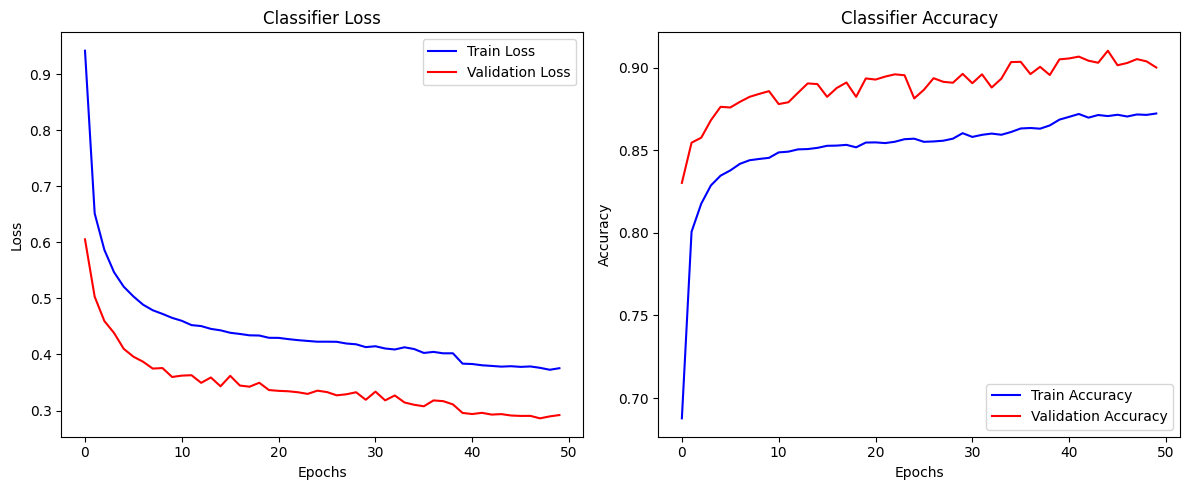

In [ ]:
import matplotlib.pyplot as plt

# Plot Classifier Training History
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
ax[0].plot(history_c.history['loss'], label='Train Loss', color='blue')
ax[0].plot(history_c.history['val_loss'], label='Validation Loss', color='red')
ax[0].set_title('Classifier Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot Accuracy
ax[1].plot(history_c.history['accuracy'], label='Train Accuracy', color='blue')
ax[1].plot(history_c.history['val_accuracy'], label='Validation Accuracy', color='red')
ax[1].set_title('Classifier Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
classifier.save(DIR + "models/classifier/classifier_model.keras")  # Saves as HDF5 file

Final Test Accuracy: 90.61%
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report:
              precision    recall  f1-score   support

    Balanced       0.91      0.87      0.89     12757
        HCLF       0.92      0.93      0.92     12110
        HPLC       0.94      0.95      0.95     13419
        Junk       0.88      0.84      0.86     10098
        LCHF       0.86      0.94      0.90     14356
      LCHFib       0.94      0.88      0.91      9970

    accuracy                           0.91     72710
   macro avg       0.91      0.90      0.90     72710
weighted avg       0.91      0.91      0.91     72710



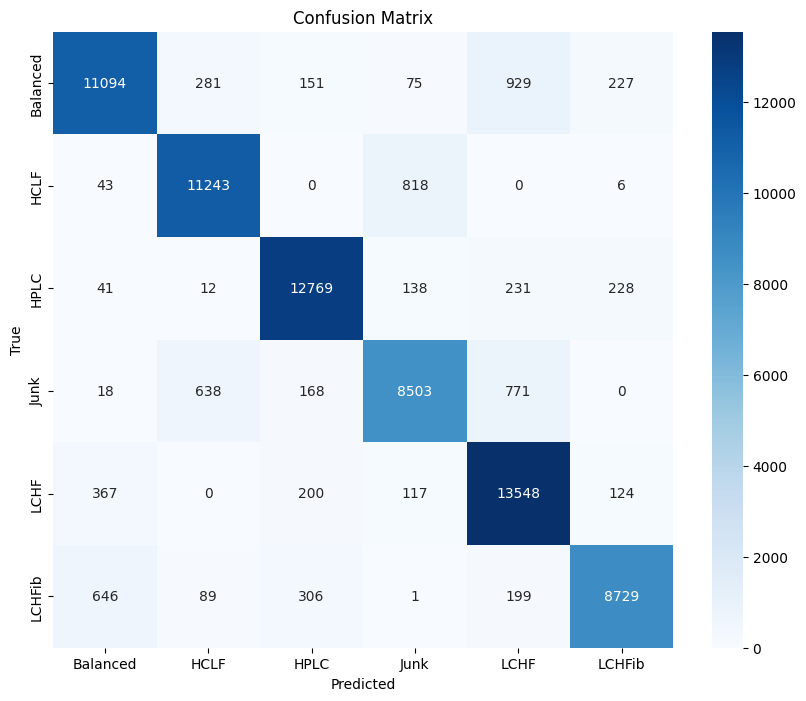


Random Forest Baseline Accuracy: 99.61%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Evaluate on Test Set
test_loss, test_acc = classifier.evaluate(X_image, y_encoded, verbose=0)
print(f"Final Test Accuracy: {test_acc:.2%}")

# 2. Predictions
y_pred = classifier.predict(X_image)
y_pred_classes = np.argmax(y_pred, axis=1)

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_encoded, y_pred_classes, target_names=le.classes_))

# 4. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_encoded, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()